In [23]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
df = pd.read_csv("dummydata_testgrad.csv")

In [25]:
bad_airports = {
    'MELBOURNE': 'MEL',
    'KUALA-LUMPUR': 'KCH',
    'BANGKOK': 'BKK',
    'SHANGHAI': 'PVG'
}

In [26]:
column_label_2 = ['Source', 'Medium']
column_label_3 = ['index3','Funnelstep', 'Origin', 'Destination', 'DepartureDay', 'DepartureMonth', 'DepartureYear',
                  'ReturnDay','ReturnMonth','ReturnYear','AdultNo','ChildNo','InfantNo', 'Class']

In [27]:
s2 = pd.DataFrame(df['Source / Medium'].str.split('/').tolist(), columns = column_label_2)

In [62]:
df['index1'] = df.index
s2['index2'] = s2.index

m1 = pd.merge(df,s2,how='inner',left_on='index1',right_on='index2')

In [63]:
page_df = df['Page'].str[1:].str.split('/')

oneway_tickets = []
return_tickets = []

idx = -1

for i in page_df:
    idx = idx + 1
    departure_date = datetime.strptime(i[3], '%d%b%Y') 
    
    origin = i[1]
    destination = i[2]
    
    if origin in bad_airports:
        origin2 = bad_airports[origin]
    else:
        origin2 = origin
        
    if destination in bad_airports:
        destination2 = bad_airports[destination]
    else:
        destination2 = destination
    
    if len(i) == 8:
        amended_row = [idx,i[0],origin2,destination2,departure_date.day,departure_date.month,departure_date.year,0,0,0] + i[4:]
        oneway_tickets.append(amended_row)
            
    elif len(i) == 9:
        return_date = datetime.strptime(i[4], '%d%b%Y')
        amended_row = [idx,i[0],origin2,destination2,departure_date.day,departure_date.month,departure_date.year,
                               return_date.day,return_date.month,return_date.year] + i[5:]
        return_tickets.append(amended_row)
        

final_list = oneway_tickets + return_tickets

page_df_cleansed = pd.DataFrame(final_list, columns=column_label_3)

page_df_cleansed[['AdultNo','ChildNo','InfantNo']] = page_df_cleansed[['AdultNo','ChildNo','InfantNo']].apply(pd.to_numeric)

result = pd.merge(m1,page_df_cleansed,how='inner',left_on='index1',right_on='index3')

result['Avg. Time on Page'] = result['Avg. Time on Page'].apply(lambda x: '00:00:01' if x == '<00:00:01' else x)

time_lst = [datetime.strptime(i,'%H:%M:%S') for i in result['Avg. Time on Page']]
result['AvgTimeOnPageHour'] = [i.hour for i in time_lst]
result['AvgTimeOnPageMinute'] = [i.minute for i in time_lst]
result['AvgTimeOnPageSecond'] = [i.second for i in time_lst]
result['AvgTimeOnPageSeconds'] = result['AvgTimeOnPageHour'] * 3600 + result['AvgTimeOnPageMinute'] * 60 + result['AvgTimeOnPageSecond']
result['Bounce Rate'] = result['Bounce Rate'].str[:-1].astype('float32')

#Drop unused columns
result = result.drop('Avg. Time on Page',1)
result = result.drop('index1',1)
result = result.drop('index2',1)
result = result.drop('index3',1)
result = result.drop('Source / Medium',1)
result = result.drop('Page',1)
result = result.drop('AvgTimeOnPageHour',1)
result = result.drop('AvgTimeOnPageMinute',1)
result = result.drop('AvgTimeOnPageSecond',1)

In [75]:
# Let's create a csv with the cleaned dataset

result.to_csv('dummydata_testgrad_cleaned.csv')

In [67]:
question1 = result[['Origin','Destination','Month','Year','Unique Pageviews']]
question1_with_agg_upv = question1.groupby(['Year','Month','Origin','Destination'],as_index = False)['Unique Pageviews'].sum()
question1_windowed_upv = question1_with_agg_upv.sort_values('Unique Pageviews', ascending=False).groupby(['Year','Month'],as_index = True).head(10)
question1_sorted_window = question1_windowed_upv.sort_values(['Year','Month','Unique Pageviews'],ascending=False)
question1_sorted_window['Rank'] = question1_sorted_window.groupby(['Year','Month'])['Unique Pageviews'].rank(ascending=False, method='first').astype('int')
question1_sorted_window.reset_index().drop('index',1)
q1_a= question1_sorted_window.reset_index().drop('index',1)
#q1_a.to_csv("Question_1.csv")

In [68]:
question2 = question1.groupby(['Origin','Destination'],as_index = False)['Unique Pageviews'].sum()
question2_sorted = question2.sort_values('Unique Pageviews',ascending=False).head(10)
question2_sorted['Rank'] = question2_sorted['Unique Pageviews'].rank(ascending=False, method='first').astype('int')
q2_a = question2_sorted.reset_index().drop('index',1)
#q2_a.to_csv("Question_2.csv")

In [69]:
result.describe()

,Year,Pageviews,Unique Pageviews,Bounce Rate,DepartureDay,DepartureMonth,DepartureYear,ReturnDay,ReturnMonth,ReturnYear,AdultNo,ChildNo,InfantNo,AvgTimeOnPageSeconds
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2015.250000,5.123900,3.775900,2.664280,16.07015,7.80095,2015.680550,11.58260,3.795100,1494.363650,1.355250,0.082500,0.082500,15.475800
std,0.433024,9.391765,33.562919,11.545127,8.85945,4.44573,0.626834,10.36913,4.299098,882.927516,0.737682,0.384319,0.384319,40.308343
min,2015.000000,3.000000,1.000000,0.000000,1.00000,1.00000,2013.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2015.000000,3.000000,1.000000,0.000000,8.00000,3.00000,2015.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000
50%,2015.000000,4.000000,2.000000,0.000000,16.00000,10.00000,2016.000000,10.00000,2.000000,2016.000000,1.000000,0.000000,0.000000,8.000000
75%,2015.250000,5.000000,3.000000,0.000000,24.00000,12.00000,2016.000000,21.00000,7.000000,2016.000000,2.000000,0.000000,0.000000,12.000000
max,2016.000000,594.000000,3710.000000,100.000000,31.00000,12.00000,2017.000000,31.00000,12.000000,2017.000000,9.000000,5.000000,5.000000,1304.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e8bdbe0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f434ba8>]], dtype=object)

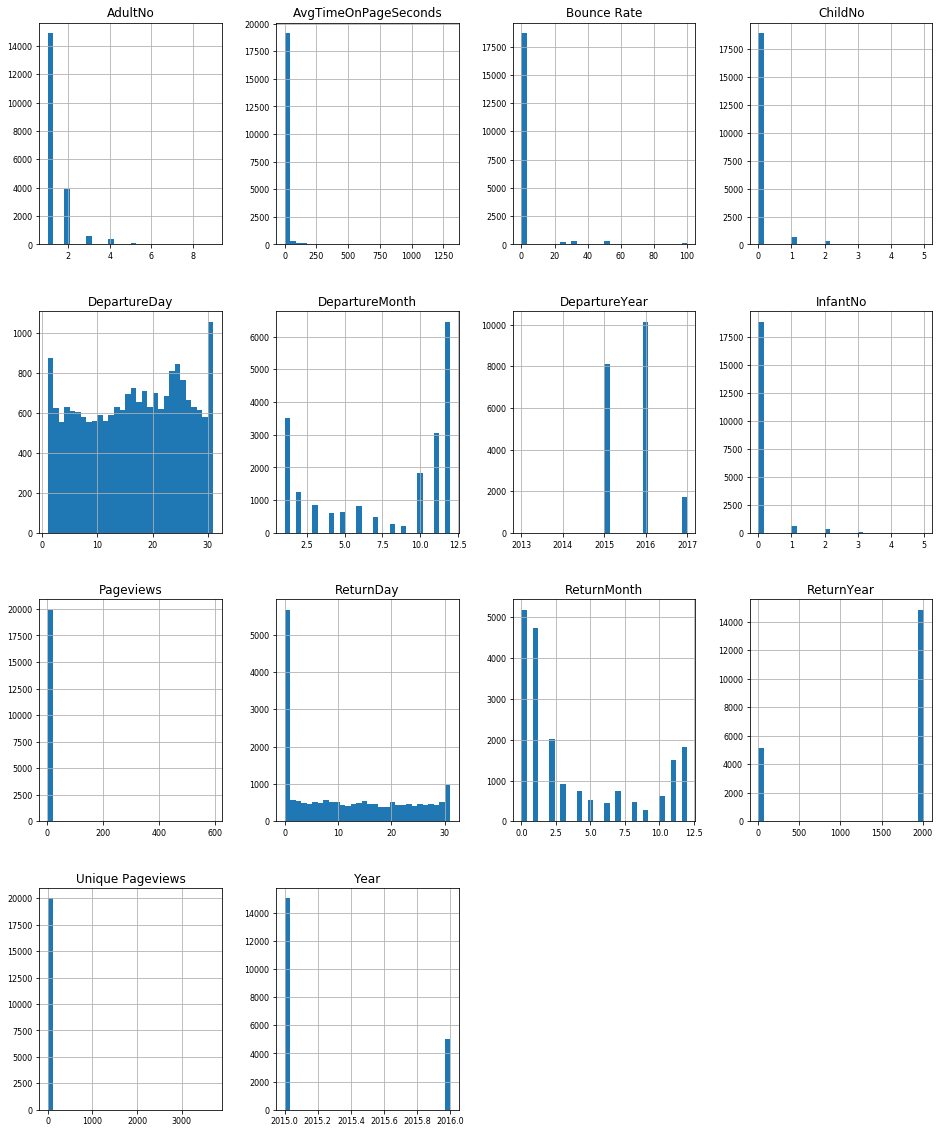

In [74]:
result.hist(figsize=(16, 20), bins=30, xlabelsize=8, ylabelsize=8)

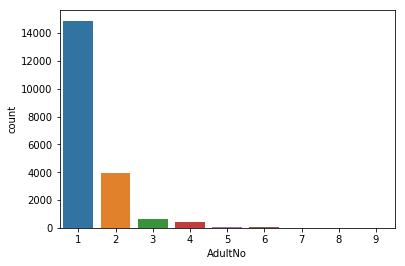

In [74]:
ax = sns.countplot(x="AdultNo", data=result)

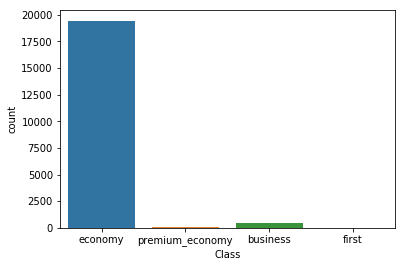

In [36]:
ax = sns.countplot(x="Class", data=f)

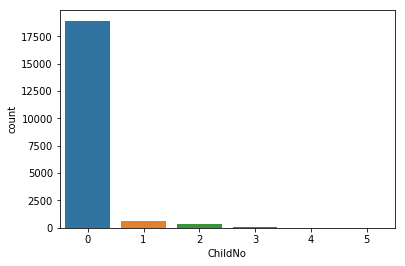

In [38]:
ax = sns.countplot(x="ChildNo", data=result)

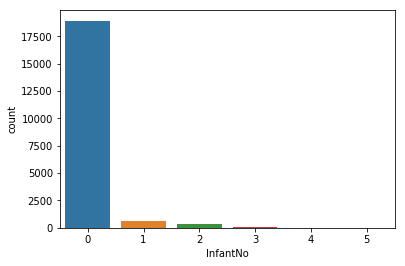

In [40]:
ax = sns.countplot(x="InfantNo", data=result)

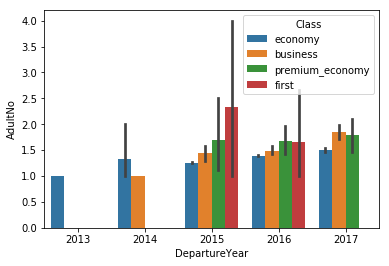

In [39]:
sns.barplot(x="DepartureYear", y="AdultNo", hue="Class", data=result);

In [22]:
pd.crosstab(result['Class'],result['AdultNo'], margins=True)

AdultNo,1,2,3,4,5,6,7,8,9,All
Class,,,,,,,,,,
business,261,184,14,13,3,0,0,0,0,475
economy,14576,3708,590,401,87,52,7,3,1,19425
first,8,1,0,3,0,0,0,0,0,12
premium_economy,48,29,5,3,1,2,0,0,0,88
All,14893,3922,609,420,91,54,7,3,1,20000
